전체 과정

0. 인코더, 디코드 설계 
1. 데이터 수집
    - https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv
2. 데이터 전처리하기
    - 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축
3. SubwordTextEncoder 사용하기
4. 트랜스포머 모델 구성하기
5. 예측 모델 평가하기
6. 추가 실험
7. 회고

In [1]:
# 주요 라이브러리 버전 확인
import tensorflow

print(tensorflow.__version__)

2.6.0


In [3]:
# 사용 라이브러리 임포트

import tensorflow as tf
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 0. 인코더, 디코더 설계

In [ ]:
# 포지셔널 인코딩 레이어 (인코더, 디코더에 위치 정보 추가를 위한 입력 처리)
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [11]:
# 스케일드 닷 프로덕트 어텐션 함수 (벡터 내적)
# 어텐선: 단어들 간의 유사도를 구하는 메커니즘
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [12]:
# 트렌스포머의 인코더, 디코더에서 사용하는 멀티헤드 어텐션 메커니즘 (병렬로 수행)

class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [13]:
# 인코딩, 디코딩 레이어를 위한 어텐션 작업 시에 사용할 마스킹 함수
# 마스킹: 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [14]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [17]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [18]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [19]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 1. 데이터 수집

- 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용

In [28]:
# 사전에 다운로드 받은 경로를 통해 데이터 불러오기
filepath = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(filepath)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 11823


In [20]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 2. 데이터 전처리

In [25]:
# 중복 제거 및 Null 값 제거
data.drop_duplicates(inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 11823


In [51]:
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)  # white space 데이터를 empty value로 변경

    # (문자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^\w\W\.\?!,]', "", sentence)
    #  자음이 2개 이상 반복되면 2개만
    sentence = re.sub(r'([ㄱ-ㅎ])\1+', r'\1\1', sentence)
    return sentence.strip()

In [43]:
# Q 데이터 전처리
clean_q = data['Q'].apply(lambda x: preprocess_sentence(x)).tolist()

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_q[:5])

Text 전처리 후 결과:  ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']


In [52]:
# A 데이터 전처리
clean_a = data['A'].apply(lambda x: preprocess_sentence(x)).tolist()

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_a[:5])

Text 전처리 후 결과:  ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [53]:
data['Q'] = clean_q
data['A'] = clean_a

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
df_cleaned = data.copy(deep=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 11823


## 3. 토크나이저

In [54]:
import tensorflow_datasets as tfds


# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data['Q'] + data['A'], target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8364]
END_TOKEN의 번호 : [8365]


In [56]:
# 토큰화 된 100개의 서브워드들을 출력
print(tokenizer.subwords[:100])

[' .', ' ?', '거예요', '게_', '수_', '너무_', '는_', '더_', '거_', '좋아하는_', '이_', ' . ', '을_', '도_', '잘_', '고_', '것_', '요', '많이_', '안_', '같아요', '좋은_', '한_', '좀_', '있어요', '가_', '은_', '나_', '있을_', '에_', '지_', '해보세요', '할_', '사람_', '면_', '건_', ' !', '사람이_', '마세요', '를_', '다_', '하고_', '하는_', '보세요', '해', '죠', '의_', '서_', '내가_', '싶어', '지', '내_', '네', '마음이_', '이제_', '만_', '썸_', '어떻게_', '어', '같아', '있는_', '왜_', '다른_', '세요', '나', '수도_', '시간이_', '다시_', '다', '그_', '것도_', '또_', '좋을_', '오늘_', '정말_', '싶다', '같이_', '가', '이', '네요', '될_', '해요', '자꾸_', '걸_', '없어요', '하세요', '있어', '로_', '일_', '길_', '바랄게요', '까', '돼요', '에서_', '봐요', '하면_', '할까', '으로_', '때_', '될까']


In [55]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8366


In [68]:
# 토크나이저 임의 데이터 확인

sample_string = data['A'][21]
print ('기존 문장 : {}'.format(sample_string))

# 인코딩한 결과를 tokenized_string에 저장
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 : {}'.format(tokenized_string))

# 이를 토크나이저로 다시 디코딩
original_string = tokenizer.decode(tokenized_string)
print ('인코딩 후 디코딩된 문장 : {}'.format(original_string))

기존 문장 : 다음 달에는 더 절약해봐요 .
정수 인코딩 후의 문장 : [2685, 7669, 8, 6378, 95, 1]
인코딩 후 디코딩된 문장 : 다음 달에는 더 절약해봐요 .


In [67]:
# 임의의 21번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(clean_q[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(clean_a[21])))

정수 인코딩 후의 21번째 질문 샘플: [5828, 605, 2500, 4174]
정수 인코딩 후의 21번째 답변 샘플: [2685, 7669, 8, 6378, 95, 1]


Q의 최소 길이 : 1
Q의 최대 길이 : 16
Q의 평균 길이 : 3.9402858834475176
A의 최소 길이 : 1
A의 최대 길이 : 24
A의 평균 길이 : 4.71589275141673


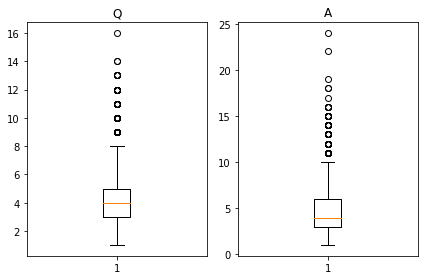

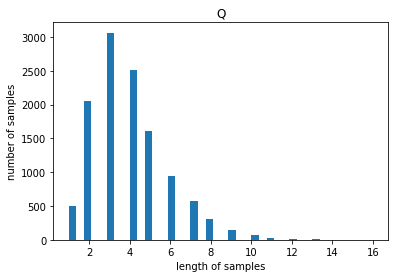

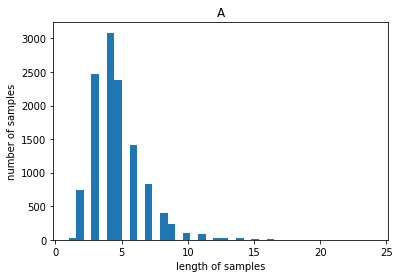

In [75]:
# 길이 분포 출력


text_len = [len(s.split()) for s in data['Q']]
summary_len = [len(s.split()) for s in data['A']]

print('Q의 최소 길이 : {}'.format(np.min(text_len)))
print('Q의 최대 길이 : {}'.format(np.max(text_len)))
print('Q의 평균 길이 : {}'.format(np.mean(text_len)))
print('A의 최소 길이 : {}'.format(np.min(summary_len)))
print('A의 최대 길이 : {}'.format(np.max(summary_len)))
print('A의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Q')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('A')
plt.tight_layout()
plt.show()

plt.title('Q')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('A')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [87]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
questions = data['Q'].values.tolist()
answers = data['A'].values.tolist()

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 20 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 20으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [88]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8366
필터링 후의 질문 샘플 개수: 11791
필터링 후의 답변 샘플 개수: 11791


In [89]:
# 교사 강요

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 3. 모델 정의 및 학습

In [90]:
# 트렌스포머 함수 

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

모델 생성

In [91]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195904     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

손실함수

In [92]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


In [93]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

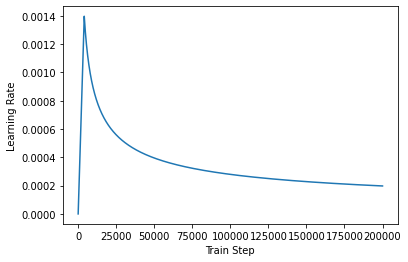

In [94]:
# 학습률 설정
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

모델 컴파일

In [95]:
# 학습률 정의
learning_rate = CustomSchedule(D_MODEL)

# 옵티마이저 정의
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 훈련

In [107]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 7s 38ms/step - loss: 0.0865 - accuracy: 0.3370
Epoch 2/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0829 - accuracy: 0.3375
Epoch 3/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0745 - accuracy: 0.3395
Epoch 4/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0637 - accuracy: 0.3420
Epoch 5/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0568 - accuracy: 0.3435
Epoch 6/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0509 - accuracy: 0.3449
Epoch 7/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0452 - accuracy: 0.3466
Epoch 8/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0406 - accuracy: 0.3480
Epoch 9/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0377 - accuracy: 0.3484
Epoch 10/30
185/185 [==============================] - 7s 37ms/step - loss: 0.0344 - accura

## 5. 예측단계

- 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
1) 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
2) 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
3) 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
4) 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
5) END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [98]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [99]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [105]:
sentence_generation('점심 뭐 먹을까?')

입력 : 점심 뭐 먹을까?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [108]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 하늘을 보고 웃어보세요 .


'하늘을 보고 웃어보세요 .'

In [115]:
sentence_generation('너 괜찮은거야?')

입력 : 너 괜찮은거야?
출력 : 많은 걸 하고 싶은데 아직 못하는게 많아요 .


'많은 걸 하고 싶은데 아직 못하는게 많아요 .'

In [116]:
sentence_generation('아 미안')

입력 : 아 미안
출력 : 많이 허전한히 잘 수 있을 거예요 .


'많이 허전한히 잘 수 있을 거예요 .'

## 6. 추가 실험

EPOCH = 50

- 학습에 따른 손실값과 정확도
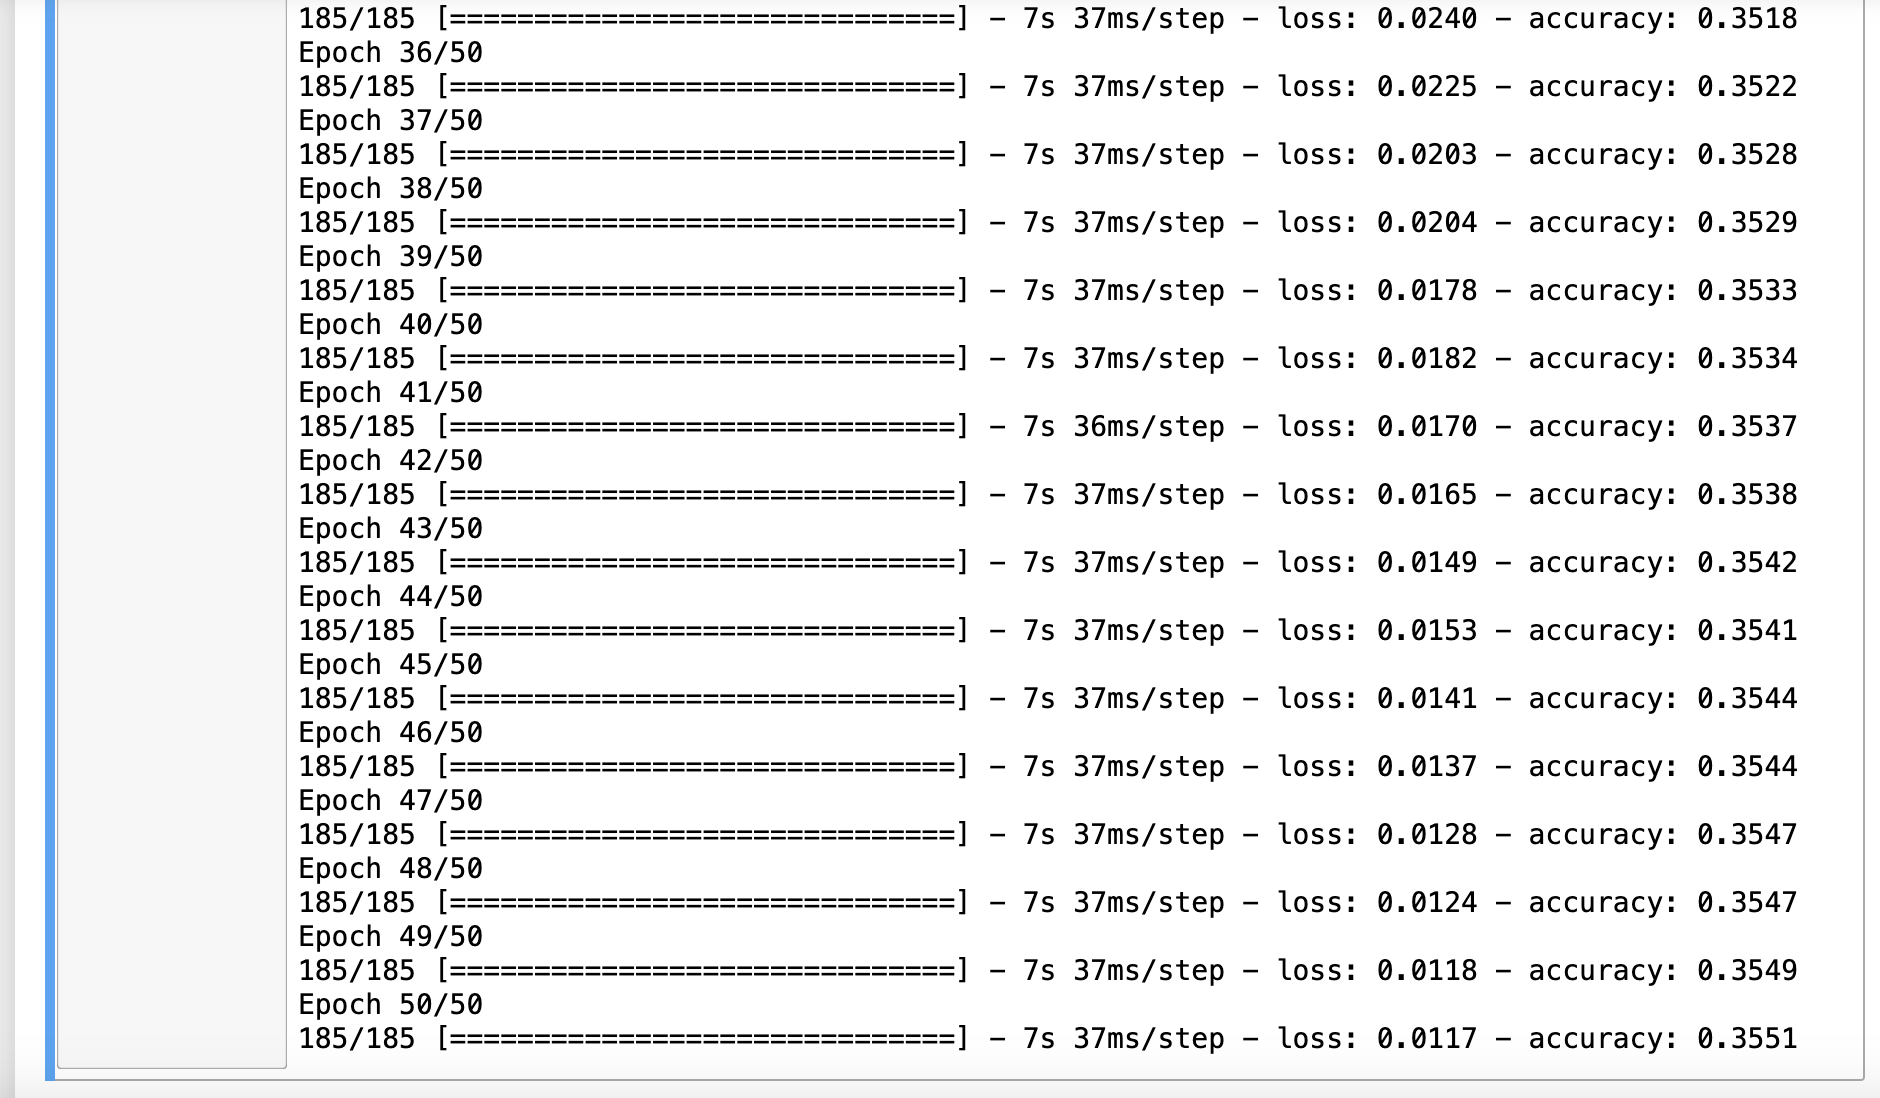

- 동일한 질문에 대한 답변
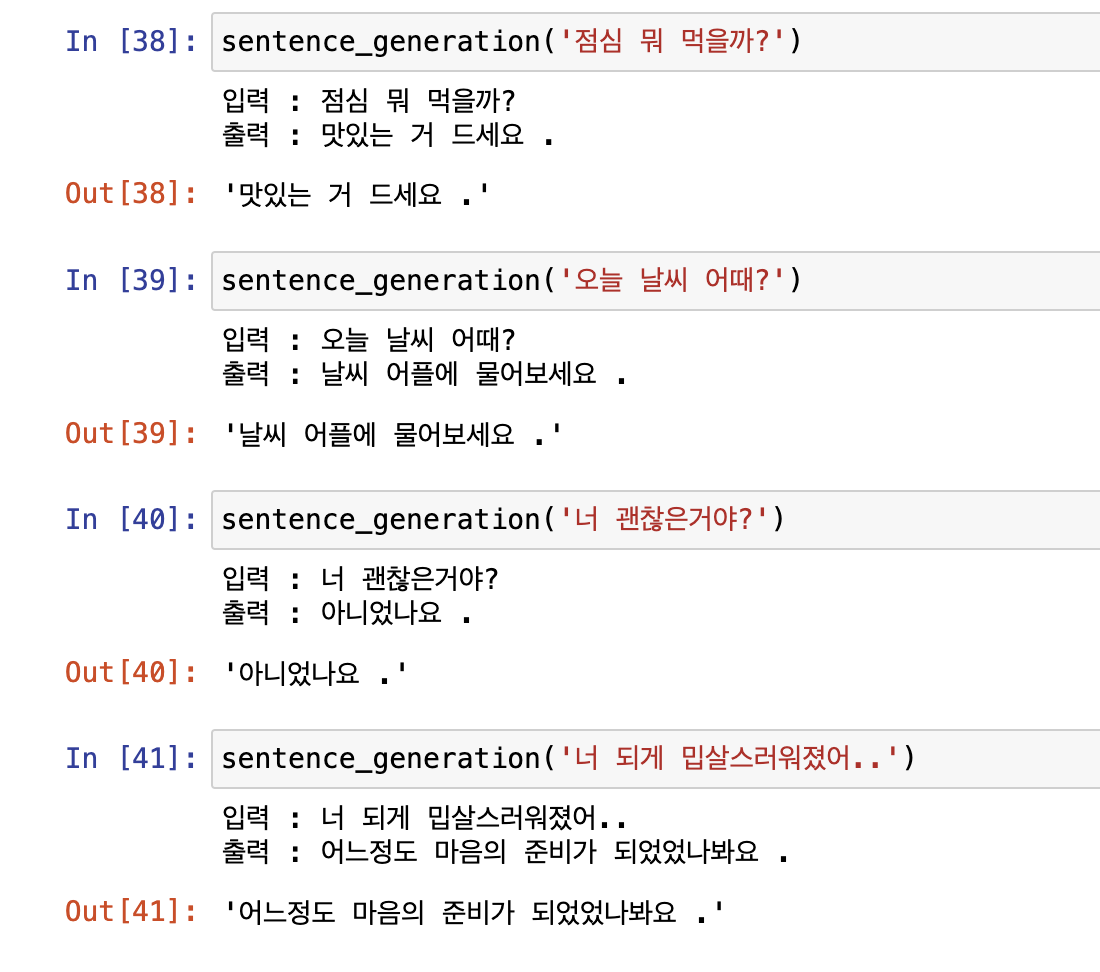

EPOCH = 50, dropout = 0.3

- 실험결과
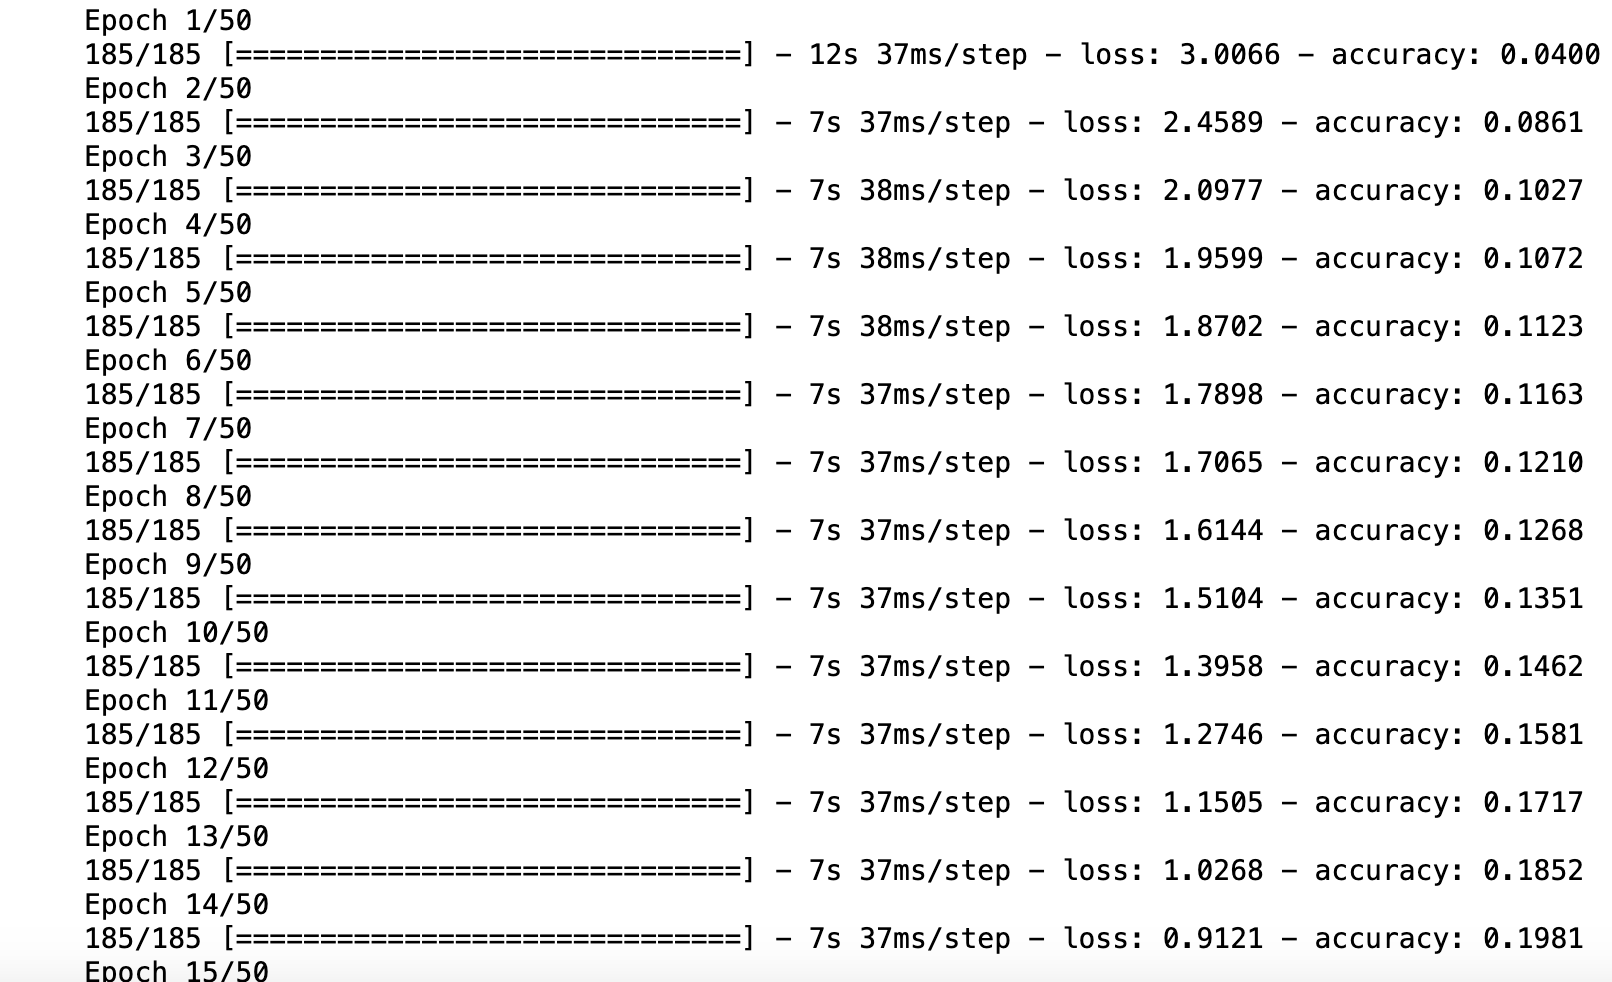
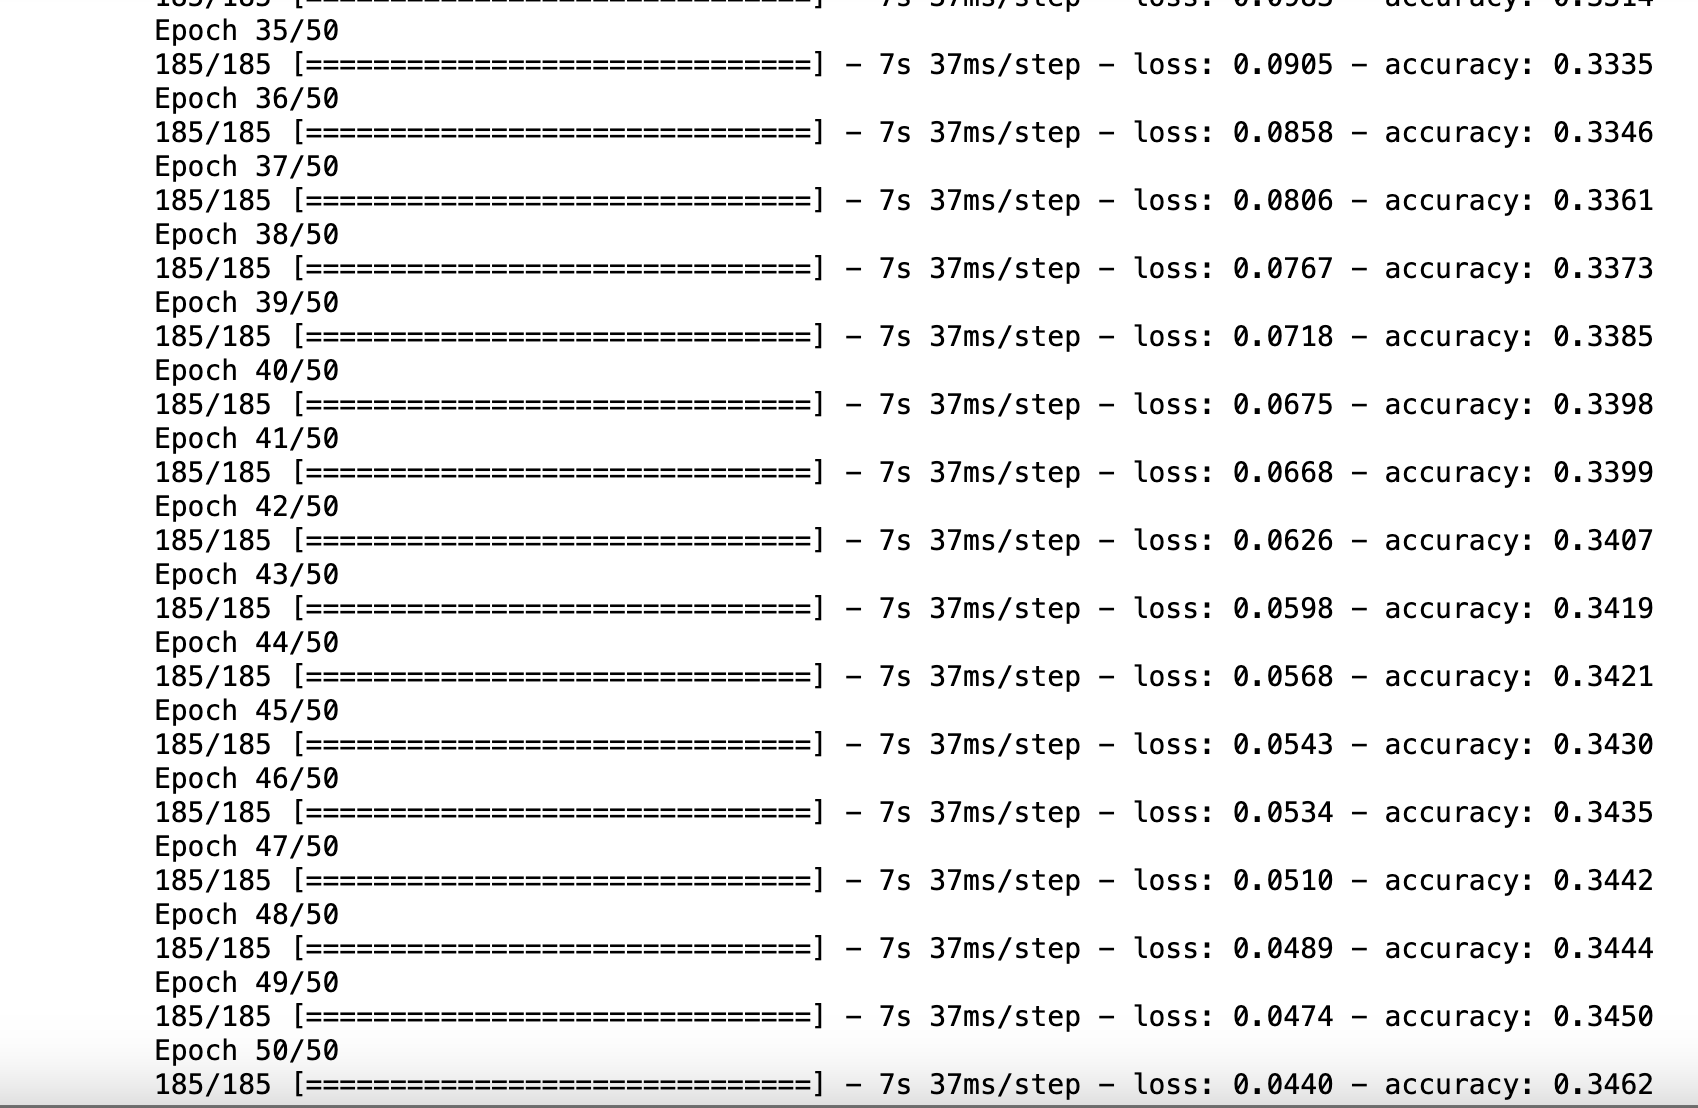


- 동일한 질문에 대한 답변
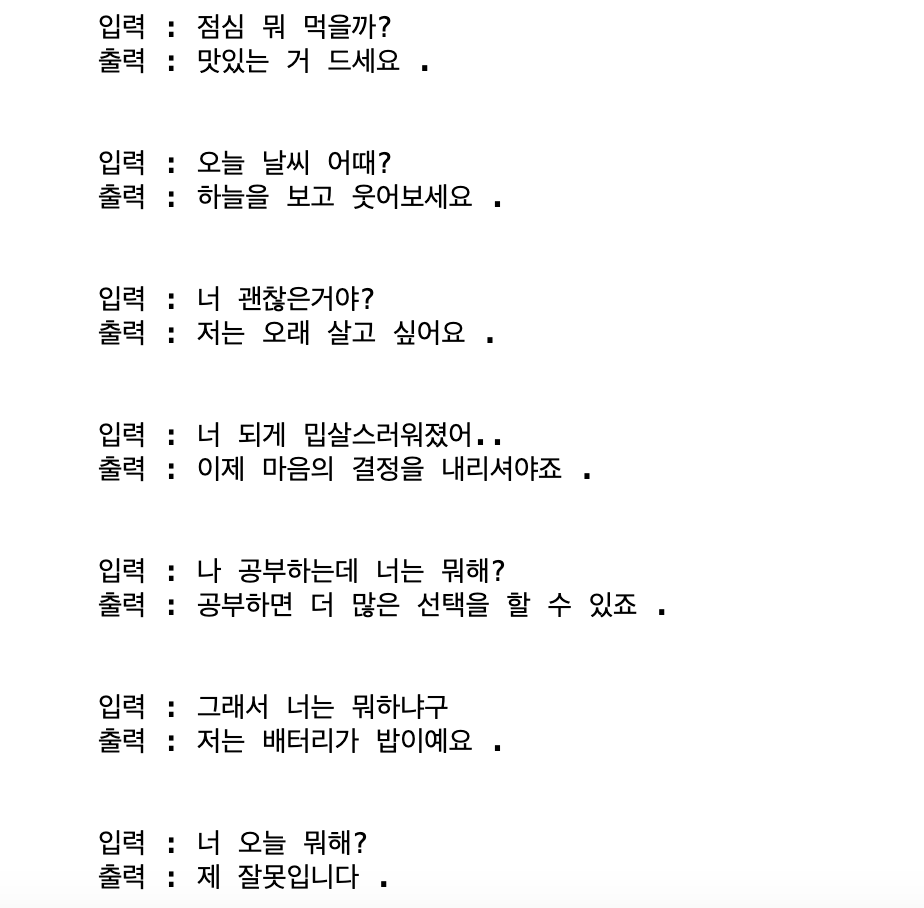

## 7. 회고

- 에포크를 증가할수록 정확도가 좋아져서 동일한 질문에 대해 매끄러운 답변을 주는 걸 볼 수 있었다. 
    - 하지만 뭔가 차가운 느낌이 든다.. 섭섭하다.. 
- 근데 dropout을 증가했더니 문맥에 안 맞는 말이 더 많아짐
- 데이터세트에 라벨이 있어서 검증셋을 구분해서 학습해보고 싶었는데 시간 내에 진행이 어려워 못해봐서 아쉽다